In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
from cobra.core import Reaction
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


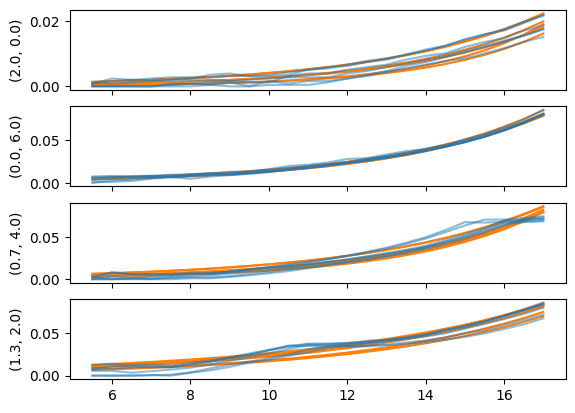

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

with open("../data/clean/CUE2/dFBA.pkl", "rb") as f:
    dFBA = pickle.load(f)

# Make keys easier to index
dFBA = {(k[0].magnitude, k[1].magnitude): v for k, v in dFBA.items()}

# Estimate growth rates and plot
growth_rates = {k : [] for k in dFBA.keys()}

fig, axs = plt.subplots(len(dFBA), 1, sharex=True)

for ax, (condition, data) in zip(axs, dFBA.items()):
    b_t, b = data["raw"]["raw_b_t"], data["raw"]["raw_b"]

    # Don't fit lag or stationary phase
    b = b[:, (5 < b_t) & (b_t <= 17)]
    b_t = b_t[(5 < b_t) & (b_t <= 17)]
    
    # Estimate the growth rate(s)
    for i in range(b.shape[0]):
        x0, mu = curve_fit(lambda t, x0, mu: x0 * np.exp(mu * t), b_t, b[i,:], p0=(b[i,0], 1))[0]
        growth_rates[condition].append(mu)

        # Plot the fit
        ax.plot(b_t, [x0 * np.exp(mu * t) for t in b_t], color="tab:orange", label="Fit")

    # Plot the data
    ax.plot(b_t, b.T, color="tab:blue", alpha=0.5, label="Data")
    ax.set_ylabel(f"({condition[0]:.1f}, {condition[1]:.1f})")

-4.0 0.0 0.30835592884757257
0.0 -14.65262833614064 0.25342267277137687
-1.3333333333333333 -12.0 0.3354013598585093
-2.6666666666666665 -6.0 0.3272868108296725


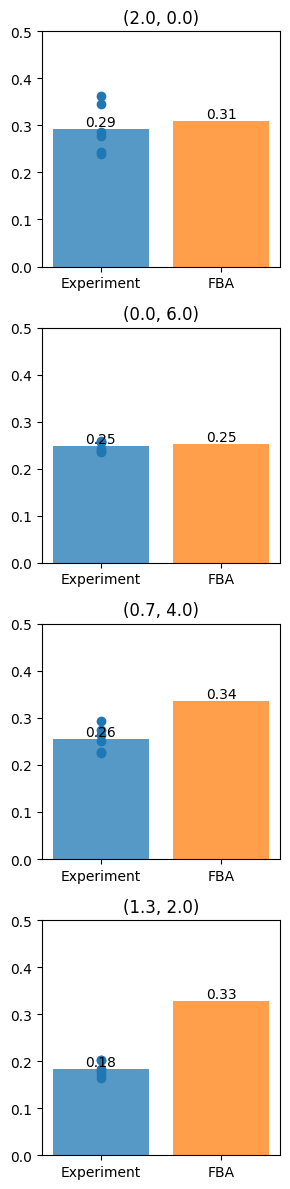

In [4]:
# Plot fitted growth rates
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
for ax, (condition, rates) in zip(axs, growth_rates.items()):
    ax.bar(0, np.mean(rates), alpha=0.75, color="tab:blue")
    ax.text(0, np.mean(rates), f"{np.mean(rates):.2f}", ha="center", va="bottom")
    ax.scatter([0] * len(rates), rates, color="tab:blue")
    
    with model:
        # TODO: constrain as instananeous uptake rates
        ex_glc.lower_bound = -2 * condition[0]
        ex_ace.lower_bound = -3 * condition[1]
        
        sol = model.optimize()

        print(ex_glc.flux, ex_ace.flux, sol.objective_value)
    ax.bar(1, sol.objective_value, color="tab:orange", alpha=0.75)
    ax.text(1, sol.objective_value, f"{sol.objective_value:.2f}", ha="center", va="bottom")

    ax.set_title(f"({condition[0]:.1f}, {condition[1]:.1f})")
    ax.set_ylim(0, 0.5)
    ax.set_xticks([0, 1], ["Experiment", "FBA"])

fig.tight_layout()

In [5]:
with model:
    # Add new ETC reactions
    ubiquinones = [model.metabolites.get_by_id(ubi)
                    for ubi in [
                        "UBIQUINONE-6[c]",
                        "UBIQUINONE-8[c]",
                        "UBIQUINONE-9[c]",
                        "UBIQUINONE-10[c]"]]
    ubiquinols = [model.metabolites.get_by_id(ubi)
                    for ubi in [
                        "UBIQUINOL-30[c]",
                        "CPD-9956[c]",
                        "CPD-9957[c]",
                        "CPD-9958[c]"
                    ]]
    
    # Replace all ubiquinones with ubiquinone-10, same with ubiquinols. IDK.
    ubiquinone10 = model.metabolites.get_by_id("UBIQUINONE-10[c]")
    ubiquinol10 = model.metabolites.get_by_id("CPD-9958[c]")
    for rxn in model.reactions:
        metabolites_copy = rxn.metabolites.copy()
        for met, coeff in metabolites_copy.items():
            if met in ubiquinones or met in ubiquinols:
                print(f"{rxn.id},{rxn.reaction}")
                break
            # if met in ubiquinones:
            #     rxn.add_metabolites({met : -coeff, ubiquinone10 : coeff})
            # if met in ubiquinols:
            #     rxn.add_metabolites({met : -coeff, ubiquinol10 : coeff})

1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56.,ETF-Reduced[c] + UBIQUINONE-10[c] --> CPD-9958[c] + ETF-Oxidized[c] + PROTON[c]
1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40.,NADH[c] + 5.0 PROTON[c] + UBIQUINONE-10[c] <=> CPD-9958[c] + NAD[c] + 4.0 PROTON[e]
BiomassRxn,0.000162290114245086 10-FORMYL-DIHYDROFOLATE-GLU-N[c] + 0.000162290114245086 5-METHYL-THF-GLU-N[c] + 0.00845926363395877 AMMONIUM[c] + 0.156860097256703 ARG[c] + 0.164924907469059 ASN[c] + 0.110131793770428 ATP[c] + 0.00338370545358347 CA+2[c] + 0.000162290114245086 CHORISMATE[c] + 0.00338370545358347 CL-[c] + 0.00225580363572238 CO+2[c] + 0.000418708494752947 CO-A[c] + 0.0140644492801629 CPD-12819[c] + 0.026182322662448 CPD-12819[p] + 0.016589736931464 CPD-17086[c] + 0.0308470901294347 CPD-17086[p] + 0.00225580363572238 CPD-3[c] + 0.000162290114245086 CPD-9956[c] + 0.00877614088277856 CPD0-2278[p] + 0.0871099352875176 CTP[c] + 0.00225580363572238 CU+2[c] + 0.036347010785427 CYS[c] + 0.0

In [6]:
etc_rxns_prefs = ["1.6.99.5-RXN", "RXN-14970", "SUCCINATE-DEHYDROGENASE-", "1.10.2.2-RXN"]
for pref in etc_rxns_prefs:
    print([rxn for rxn in model.reactions if rxn.id.startswith(pref)])

[<Reaction 1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40. at 0x7f0dc881cfd0>]
[<Reaction RXN-14970 at 0x7f0dc7915d20>]
[]
[<Reaction 1.10.2.2-RXN at 0x7f0dc79179a0>]


/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/ve

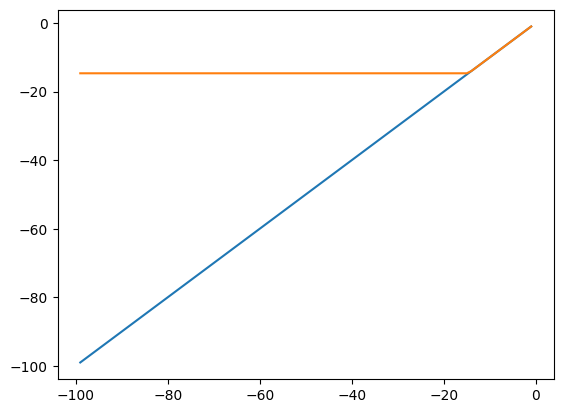

In [7]:
import warnings 

bound = -np.arange(1, 100, 1)
uptake = []
for b in bound:
    with model:
        ex_ace.lower_bound = b
        sol = model.optimize()
        uptake.append(ex_ace.flux)

fig, ax = plt.subplots()
ax.plot(bound, bound)
ax.plot(bound, uptake)

In [8]:
# Find which metabolite(s) are limiting when acetate uptake is >20
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20
    sol = model.optimize()
    
# for rxn in {ex_ace.id : ..., **model.medium}:
#     rxn = model.reactions.get_by_id(rxn)
#     print(rxn, rxn.flux)

sp = sol.shadow_prices.sort_values(ascending=False).head(10)
sp

# red_costs = sol.reduced_costs.abs().sort_values(ascending=False)

# for rxn in red_costs.index:
#     has_p_met = False
#     for met in model.reactions.get_by_id(rxn).metabolites:
#         if met.id.endswith("[e]"):
#             has_p_met = True
#             break
    
#     if has_p_met:
#         print(rxn, red_costs[rxn])

CPD-13704[c]               0.520827
ADENOSYLCOBINAMIDE[c]      0.514055
ADENOSYLCOBINAMIDE-P[c]    0.503568
CPD-13708[c]               0.492208
CPD-13680[c]               0.492208
CPD-15874[c]               0.484999
CPD-13711[c]               0.475604
16-HYDROXYPALMITATE[c]     0.472764
CPD-17640[c]               0.472764
CPD-10825[c]               0.468395
Name: shadow_prices, dtype: float64

In [9]:
from cobra.core import Reaction

# Add KDO2-LIPID-A[c] to objective and see if growth changes

with model:
    biomass = model.reactions.get_by_id("Rpom_hwa_biomass")
    biomass.add_metabolites({model.metabolites.get_by_id("KDO2-LIPID-A[c]") : -0.001})

    ex_ace.lower_bound = -20
    print(model.optimize().objective_value)

0.2529860452213348


In [10]:
model.reactions.get_by_id("Rpom_hwa_biomass")

Reaction identifier,Rpom_hwa_biomass
Name,Rpom_hwa_biomass
Memory address,0x7f0dc78c9a80
Stoichiometry,31.36179486 ATP[c] + 0.001524574 COFACTORS[c] + 0.05136379 DNA[c] + 0.009825009 IONS[c] + 0.095950926 LIPID[c] + 0.527175919 MUREIN[c] + 0.000447 NADP[c] + 0.001831 NAD[c] + 0.091372857 PHB-... 31.36179486 ATP + 0.001524574 + 0.05136379 + 0.009825009 + 0.095950926 + 0.527175919 + 0.000447 NADP+ + 0.001831 NAD+ + 0.091372857 + 0.561521914 + 0.093597842 + 48.601527 H2O --> 31.36179573 ADP +...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [11]:
model.reactions.get_by_id("NI2tex").flux

8.171449272731526e-05

In [12]:
model.medium

{'EX_ca2': 1000.0,
 'EX_cl': 1000.0,
 'EX_co2': 1000.0,
 'EX_cobalt2': 1000.0,
 'EX_cu2': 1000.0,
 'EX_fe2': 1000.0,
 'EX_fe3': 1000.0,
 'EX_h': 1000.0,
 'EX_h2o': 1000.0,
 'EX_k': 1000.0,
 'EX_mg2': 1000.0,
 'EX_mn2': 1000.0,
 'EX_mobd': 1000.0,
 'EX_na1': 1000.0,
 'EX_nh4': 1000.0,
 'EX_ni2': 1000.0,
 'EX_o2': 20.0,
 'EX_pi': 1000.0,
 'EX_slnt': 1000.0,
 'EX_so4': 1000.0,
 'EX_thm': 1000.0,
 'EX_zn2': 1000.0,
 'EX_BIOTIN[e]': 1000.0,
 'EX_NITRATE[e]': 1000.0,
 'EX_HCO3[e]': 1000.0}

In [13]:
model.reactions.get_by_id("RXN-17023")

Reaction identifier,RXN-17023
Name,RXN-17023
Memory address,0x7f0dc8043970
Stoichiometry,1-PALMITOYLGLYCEROL-3-PHOSPHATE[c] + TETRADECANOYL-COA[c] --> CO-A[c] + CPD-18390[c] 1-palmitoyl-sn-glycerol 3-phosphate + myristoyl-CoA --> coenzyme A + 1-palmitoyl-2-myristoyl phosphatidate
GPR,G1G48-346 or G1G48-2494 or G1G48-2017
Lower bound,0.0
Upper bound,1000.0
